# Dynamic Analysis
In this notebook I will analyse the flying forces excerpted by the Batbot (using the 6 axis sensor). With this more information will be gained that can be used to achieve hovering.

In [1]:
import matplotlib.pyplot as plt

from utils import *
import numpy as np
import plotly.express as px
import pandas as pd
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [2]:
!python -m serial.tools.list_ports
sensor_port = '/dev/ttyUSB0'

/dev/ttyACM0        
/dev/ttyACM1        
/dev/ttyUSB0        
3 ports found


## Calibration
I have positioned the Batbot horizontally (using the horizontal bar as reference) and calculated the force excerpted 

In [ ]:
df_calib = read_measurements_df_6axis(port=sensor_port, duration=5)

In [ ]:
px.line(df_calib,x='Time', y=sensors_col)

In [ ]:
calib = df_calib.mean()
calib['Time'] = 0

## Experiment 1
I ran a experiment with the motor at 265 and the legs still for 20 seconds at 0°

In [ ]:
df = read_measurements_df_6axis(port=sensor_port, duration=20)

In [ ]:
df = df-calib

In [ ]:
px.line(df,x='Time', y=sensors_col)

In [ ]:
df['Fres'] = np.sqrt(df.Fy**2 + df.Fz**2)
df['Angle'] = df.apply(lambda x: arctan2_degrees(x.Fz, x.Fy), axis=1)

In [ ]:
px.line(df,x='Time', y=['Fres', 'Angle'])

In [ ]:
fig = px.line(df[(df['Time'] >= 10.04193) & (df['Time'] <= 15.55)]
,x='Fy', y='Fz')#, color='Time')

fig.update_layout(
    xaxis=dict(
        scaleanchor='y',
        scaleratio=1,
    )
)

# Show plot
fig.show()

We can see that there are predominantly 2 directions of force (during upstroke and downstroke) 

## Experiment 2
I repositioned the Batbot 10°

In [ ]:
df2 = read_measurements_df_6axis(port=sensor_port, duration=20)

In [ ]:
df2 = df2 - calib

In [ ]:
px.line(df2,x='Time', y=sensors_col)

In [ ]:
df2['Fres'] = np.sqrt(df2.Fy**2 + df2.Fz**2)
df2['Angle'] = df2.apply(lambda x: arctan2_degrees(x.Fz, x.Fy), axis=1)

In [ ]:
fig = px.line(df2[(df2['Time'] >= 10.04193) & (df2['Time'] <= 15.55)]
,x='Fy', y='Fz')#, color='Time')

fig.update_layout(
    xaxis=dict(
        scaleanchor='y',
        scaleratio=1,
    )
)

# Show plot
fig.show()

## Experiment 3
I will remove the Batbot and calibrate the sensor with only the testbench and redo an experiment to see the real forces excerpted on the Batbot (including own weight)

In [ ]:
df_calib3 = read_measurements_df_6axis(port=sensor_port, duration=5)

In [ ]:
df_calib3 = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df_calib3.csv')
calib3 = df_calib3.mean()
calib3['Time'] = 0

In [ ]:
df_calib3.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df_calib3.csv', index=False)

In [ ]:
calib3.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/calib3_mean.csv')

In [ ]:
df3 = read_measurements_df_6axis(port=sensor_port, duration=60)

In [ ]:
df3 = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df3.csv')

In [ ]:
df3_calib = df3-calib3

In [ ]:
df3.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df3.csv', index=False)

In [ ]:
px.line(df3_calib, x='Time', y=sensors_col)

In [ ]:
fig = px.scatter(df3_calib[((df3_calib.Time >= 9)&(df3_calib.Time <= 12))|((df3_calib.Time >= 37)&(df3_calib.Time <= 40))]
,x='Fy', y='Fz', color='Time')

fig.update_layout(
    xaxis=dict(
        scaleanchor='y',
        scaleratio=1,
    )
)
# Show plot
fig.show()

In [ ]:
df = df3_calib.copy()
df = df[(df.Time >= 8.3) & (df.Time <= 40.1)].reset_index(drop=True)

In [ ]:

# Find peaks (adjust parameters as discussed previously)
peaks, _ = find_peaks(df['Fz'],height=-400, distance=15)
valleys, _ = find_peaks(-df['Fz'],height=400, distance=15)
# Create the base line plot
fig = px.line(df, y='Fz', title='Signal with Peaks')

# Add the peaks to the plot
fig.add_scatter(x=peaks, y=df['Fz'][peaks], mode='markers', marker=dict(size=8, color='red', symbol='cross'), name='Peaks')
fig.add_scatter(x=valleys, y=df['Fz'][valleys], mode='markers', marker=dict(size=8, color='green', symbol='cross'), name='Valleys')

# Show the plot
fig.show()



In [ ]:
# Initialize the period column with NaN values
df['Period'] = 0

# Create a list of rows from the original DataFrame, duplicating the necessary peaks
rows_list = []
for i, row in df.iterrows():
    rows_list.append(row)
    if i in peaks[1:-1]:  # Only duplicate internal peaks
        rows_list.append(row)

# Convert the list of rows back into a DataFrame
df = pd.DataFrame(rows_list).reset_index(drop=True)

# The updated peaks' indices should account for the additional rows added
offsets = np.cumsum([1 if idx in peaks[1:-1] else 0 for idx in peaks])
updated_peaks = [peak + offset for peak, offset in zip(peaks, offsets)]

# Assign period numbers using the updated peaks
for i in range(len(updated_peaks)-1):
    start = updated_peaks[i]
    end = updated_peaks[i+1]
    df.loc[start:end, 'Period'] = i + 1

In [ ]:
df = df[df.Period != 0]

In [ ]:
def interpolate_group(group):
    # Generate 1000 data points for time
    new_time = np.linspace(group['Time'].min(), group['Time'].max(), 1000)
    new_df = pd.DataFrame({'Time': new_time})

    # For each column (except 'Period'), interpolate the values based on 'Time'
    for column in group.columns:
        if column not in ['Period', 'Time']:
            new_df[column] = np.interp(new_time, group['Time'], group[column])
    
    # Assign the period value for the new dataframe
    new_df['Period'] = group['Period'].iloc[0]

    return new_df

# Apply the function to each group and concatenate results
df = df.groupby('Period').apply(interpolate_group).reset_index(drop=True)

In [ ]:
mean = df.groupby('Period').mean().reset_index()

In [ ]:
df.Period = df['Period'].astype(str)
mean.Period = mean['Period'].astype(str)

In [ ]:
# Create the first scatter plot
fig = px.scatter(df, x='Fy', y='Fz', color='Period')

# Create the scatter plot for the mean data
fig2 = px.scatter(mean, x='Fy', y='Fz', color='Period')

# Change the marker symbol for the mean data traces
for trace in fig2.data:
    trace.marker.symbol = 'star'
    trace.marker.size = 10  # Adjust size as need

# Add traces from the second scatter plot (with the different marker) to the first plot
for trace in fig2.data:
    fig.add_trace(trace)

# Update the layout properties
fig.update_layout(
    xaxis=dict(
        scaleanchor='y',
        scaleratio=1
    )
)

# Show the combined plot
fig.show()

In [ ]:
mean.Period = mean['Period'].astype(float)
fig = px.line(mean,x='Fy', y='Fz')#, color='Period')

fig.update_layout(
    xaxis=dict(
        scaleanchor='y',
        scaleratio=1,
    )
)
# Show plot
fig.show()

In [ ]:
px.scatter(df_interpolated,x='Time', y='Fz', color='Period')

## Experiment 4
I will redo the experiments using higher flapping frequencies, as from the last experiment we can see that there is indeed a force going upwards but its very low. So in this experiment I will focus on a good calibration of the wingbeat cycle and higher flapping frequencies.

In [ ]:
calib = df_calib3.mean()
calib['Time'] = 0

In [ ]:
df4 = read_measurements_df_6axis(port=sensor_port, duration=90)

In [ ]:
df4 = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df4.csv')

In [ ]:
df4 = df4 - calib

In [ ]:
px.line(df4, x='Time', y=sensors_col)

In [ ]:
df4 = df4[(df4.Time >= 9.3) & (df4.Time <= 70.05)].reset_index(drop=True)

In [ ]:
# Find peaks (adjust parameters as discussed previously)
peaks, _ = find_peaks(df4['Fz'],height=-400, distance=10)
valleys, _ = find_peaks(-df4['Fz'],height=400, distance=15)
# Create the base line plot
fig = px.line(df4, y='Fz', title='Signal with Peaks')

# Add the peaks to the plot
fig.add_scatter(x=peaks, y=df4['Fz'][peaks], mode='markers', marker=dict(size=8, color='red', symbol='cross'), name='Peaks')
fig.add_scatter(x=valleys, y=df4['Fz'][valleys], mode='markers', marker=dict(size=8, color='green', symbol='cross'), name='Valleys')

# Show the plot
fig.show()

In [ ]:
# Initialize the period column with NaN values
df4['Period'] = 0

# Create a list of rows from the original DataFrame, duplicating the necessary peaks
rows_list = []
for i, row in df4.iterrows():
    rows_list.append(row)
    if i in peaks[1:-1]:  # Only duplicate internal peaks
        rows_list.append(row)

# Convert the list of rows back into a DataFrame
df4 = pd.DataFrame(rows_list).reset_index(drop=True)

# The updated peaks' indices should account for the additional rows added
offsets = np.cumsum([1 if idx in peaks[1:-1] else 0 for idx in peaks])
updated_peaks = [peak + offset for peak, offset in zip(peaks, offsets)]

# Assign period numbers using the updated peaks
for i in range(len(updated_peaks)-1):
    start = updated_peaks[i]
    end = updated_peaks[i+1]
    df4.loc[start:end, 'Period'] = i + 1

In [ ]:
df4 = df4[df4.Period != 0]

In [ ]:
def interpolate_group(group):
    # Generate 1000 data points for time
    new_time = np.linspace(group['Time'].min(), group['Time'].max(), 1000)
    new_df = pd.DataFrame({'Time': new_time})

    # For each column (except 'Period'), interpolate the values based on 'Time'
    for column in group.columns:
        if column not in ['Period', 'Time']:
            new_df[column] = np.interp(new_time, group['Time'], group[column])
    
    # Assign the period value for the new dataframe
    new_df['Period'] = group['Period'].iloc[0]

    return new_df

# Apply the function to each group and concatenate results
df4 = df4.groupby('Period').apply(interpolate_group).reset_index(drop=True)

In [ ]:
mean4 = df4.groupby('Period').mean().reset_index()
df4.Period = df4['Period'].astype(str)
mean4.Period = mean4['Period'].astype(str)

In [ ]:
# Create the first scatter plot
fig = px.scatter(df4, x='Fy', y='Fz', color='Period')

# Create the scatter plot for the mean data
fig2 = px.scatter(mean4, x='Fy', y='Fz', color='Period')

# Change the marker symbol for the mean data traces
for trace in fig2.data:
    trace.marker.symbol = 'star'
    trace.marker.size = 10  # Adjust size as need

# Add traces from the second scatter plot (with the different marker) to the first plot
for trace in fig2.data:
    fig.add_trace(trace)

# Update the layout properties
fig.update_layout(
    xaxis=dict(
        scaleanchor='y',
        scaleratio=1
    )
)

# Show the combined plot
fig.show()

In [ ]:
mean4.Period = mean4['Period'].astype(float)
fig = px.scatter(mean4, x='Fy', y='Fz', color='Period')

fig.update_layout(
    xaxis=dict(
        scaleanchor='y',
        scaleratio=1,
    )
)
# Show plot
fig.show()

In [ ]:
df4.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df4.csv', index=False)
mean4.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/mean4.csv')

## Weight measurement
I wish to see only how much does the Batbot weight and compare it to the results of Experiment 4 to see how much is the Batbot actually lifting while flapping.

In [ ]:
df_weigth = read_measurements_df_6axis(port=sensor_port, duration=10, calibration=True)

In [ ]:
fig = px.scatter(df_weight, x='Fy', y='Fz')

fig.update_layout(
    xaxis=dict(
        scaleanchor='y',
        scaleratio=1,
    )
)
# Show plot
fig.show()

## Experiment 6
I analyze the forces when activating the legs to what I consider to be the most logicall leg movement going from motor [260, 285]:
leg_y = 90
leg_y_amplitude = 30
leg_x = 40
leg_x_amplitude = 30
ellipse_angle = 1

In [ ]:
df5 = read_measurements_df_6axis(port=sensor_port, duration=90, calibration=True)

In [ ]:
df5.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df5.csv', index=False)

In [ ]:
df5 = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df5.csv')

In [ ]:
px.line(df5, x='Time', y=sensors_col)

In [ ]:
df5 = df5[(df5.Time >= 7.6) & (df5.Time <= 70.93)].reset_index(drop=True)
# Find peaks (adjust parameters as discussed previously)
peaks, _ = find_peaks(df5['Fz'], height=-400, distance=10)
valleys, _ = find_peaks(-df5['Fz'], height=400, distance=15)
# Create the base line plot
fig = px.line(df5, y='Fz', title='Signal with Peaks')

# Add the peaks to the plot
fig.add_scatter(x=peaks, y=df5['Fz'][peaks], mode='markers', marker=dict(size=8, color='red', symbol='cross'),
                name='Peaks')
fig.add_scatter(x=valleys, y=df5['Fz'][valleys], mode='markers', marker=dict(size=8, color='green', symbol='cross'),
                name='Valleys')

# Show the plot
fig.show()

In [ ]:

# Initialize the period column with NaN values
df5['Period'] = 0

# Create a list of rows from the original DataFrame, duplicating the necessary peaks
rows_list = []
for i, row in df5.iterrows():
    rows_list.append(row)
    if i in peaks[1:-1]:  # Only duplicate internal peaks
        rows_list.append(row)

# Convert the list of rows back into a DataFrame
df5 = pd.DataFrame(rows_list).reset_index(drop=True)

# The updated peaks' indices should account for the additional rows added
offsets = np.cumsum([1 if idx in peaks[1:-1] else 0 for idx in peaks])
updated_peaks = [peak + offset for peak, offset in zip(peaks, offsets)]

# Assign period numbers using the updated peaks
for i in range(len(updated_peaks) - 1):
    start = updated_peaks[i]
    end = updated_peaks[i + 1]
    df5.loc[start:end, 'Period'] = i + 1
df5 = df5[df5.Period != 0]


def interpolate_group(group):
    # Generate 1000 data points for time
    new_time = np.linspace(group['Time'].min(), group['Time'].max(), 1000)
    new_df = pd.DataFrame({'Time': new_time})

    # For each column (except 'Period'), interpolate the values based on 'Time'
    for column in group.columns:
        if column not in ['Period', 'Time']:
            new_df[column] = np.interp(new_time, group['Time'], group[column])

    # Assign the period value for the new dataframe
    new_df['Period'] = group['Period'].iloc[0]

    return new_df


# Apply the function to each group and concatenate results
df5 = df5.groupby('Period').apply(interpolate_group).reset_index(drop=True)
mean5 = df5.groupby('Period').mean().reset_index()
df5.Period = df5['Period'].astype(str)
mean5.Period = mean5['Period'].astype(str)
# Create the first scatter plot
fig = px.scatter(df5, x='Fy', y='Fz', color='Period')

# Create the scatter plot for the mean data
fig2 = px.scatter(mean5, x='Fy', y='Fz', color='Period')

# Change the marker symbol for the mean data traces
for trace in fig2.data:
    trace.marker.symbol = 'star'
    trace.marker.size = 10  # Adjust size as need

# Add traces from the second scatter plot (with the different marker) to the first plot
for trace in fig2.data:
    fig.add_trace(trace)

# Update the layout properties
fig.update_layout(
    xaxis=dict(
        scaleanchor='y',
        scaleratio=1
    )
)

# Show the combined plot
fig.show()
mean5.Period = mean5['Period'].astype(float)
fig = px.scatter(mean5, x='Fy', y='Fz', color='Period')

fig.update_layout(
    xaxis=dict(
        scaleanchor='y',
        scaleratio=1,
    )
)
# Show plot
fig.show()

In [ ]:
df5.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df5.csv', index=False)
mean5.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/mean5.csv')

## Experiment 7
I am going to activate the motor from 260 and 280 to best create the new fitness function, the main focus of this experiment is to tune the peak finding algorithm to slice the data from a peak to a valley.
Parameters:
leg_y = 90
leg_y_amplitude = 30
leg_x = 40  # 50-140
leg_x_amplitude = 30
ellipse_angle = 1
motor = 260

In [ ]:
df_slow = read_measurements_df_6axis(port=sensor_port, duration=5, calibration=True)

In [ ]:
df_fast = read_measurements_df_6axis(port=sensor_port, duration=5, calibration=True)

In [ ]:
df_slow.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df_slow.csv', index=False)

In [ ]:
df_fast.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df_fast.csv', index=False)

### Fitness Function
Using df_slow and df_fast I would like to create the new fitnes function

In [108]:
df_slow = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df_slow.csv')
df_fast = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df_fast.csv')

In [13]:
df_new = read_measurements_df_6axis(port=sensor_port, duration=5, calibration=True)

In [15]:
df_new.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/data/df_mounted.csv', index=False)

<Axes: xlabel='Time'>

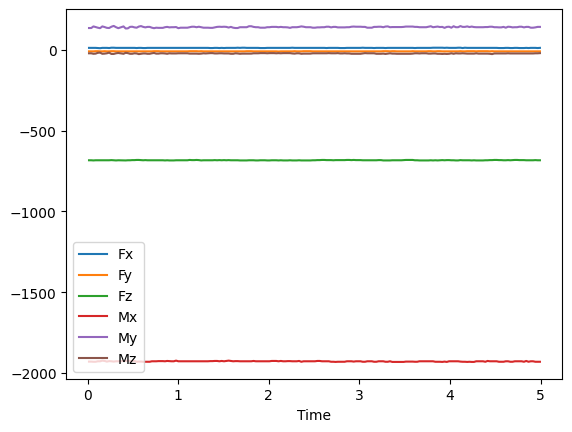

In [16]:
df_new.plot(x='Time')

In [131]:
df = df_new.copy()
plot = False
# Find peaks (adjust parameters as discussed previously)
peaks, _ = find_peaks(df['Fz'], height=-400, distance=10)
df_sliced = df.iloc[peaks[0]:peaks[-1]+1].reset_index(drop=True)
# Now create the new time series with 1000 points
new_time = np.linspace(df_sliced['Time'].min(), df_sliced['Time'].max(), 1000)       
# Initialize a new DataFrame to store the interpolated values
interpolated_df = pd.DataFrame(index=new_time)

# Interpolate each sensor column
for column in df_sliced.columns:
    if column != 'Time':
        # Create the interpolation function
        interp_func = interp1d(df_sliced['Time'], df_sliced[column], kind='linear', fill_value='extrapolate')
        # Apply the interpolation function to the new time series
        interpolated_df[column] = interp_func(new_time)

# Reset the index to make 'Time' a column again
interpolated_df.reset_index(inplace=True)
interpolated_df.rename(columns={'index': 'Time'}, inplace=True)

# interpolated_df now contains 1000 interpolated data points based on the 'Time' column.

Fy, Fz = interpolated_df.mean()[['Fy','Fz']]
score = np.sqrt(Fy**2+Fz**2)

if plot:
    # Create the base line plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    # Plot 'Fz' column
    ax1.plot(df['Time'], df['Fz'], label='Fz')
    ax1.plot(df['Time'], df['Fy'], label='Fy', zorder=1)
    # Plot the peaks
    ax1.scatter(df['Time'][peaks], df['Fz'][peaks], color='red', s=10, label='Peaks', zorder=5)
    # Adding title and labels
    ax1.legend()
    ax1.set_title('Peaks found')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Force')
    # Setting up a simple plot with equal scaling on the axes
    # Setting the aspect of the plot to be equal.
    ax2.set_aspect('equal', adjustable='box')
    
    # Drawing a simple line for demonstration
    ax2.plot(df_sliced.Fy, df_sliced.Fz, zorder=1)
    ax2.scatter(Fy, Fz, c='r', marker='*')
    ax2.scatter(0, 0, c='g', marker='+')
    ax2.arrow(0, 0, Fy, Fz, head_width=40, head_length=40)
    
    # Setting labels for the axes
    ax2.set_xlabel('Fy')
    ax2.set_ylabel('Fz')
    ax2.set_xlim(-500, 500)
    ax2.set_ylim(-1000, 500)
    ax2.set_title(f'Score: {round(score,2)}')
    
    # Display the plot
    plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [134]:
np.sqrt(df_new.mean().Fy**2 + df_new.mean().Fz**2)

648.8226051274577

# Leg movement analysis
I did the first optimization experiments and the legs were doing weird movements. I want to look deeper in the leg motion algorithm 

max values
x: 40-140
y: 30-150
leg_x = [40, 140]
leg_y =  [30, 150]
leg_x_amplitude = [0, 50]
leg_y_amplitude = [0, 60]

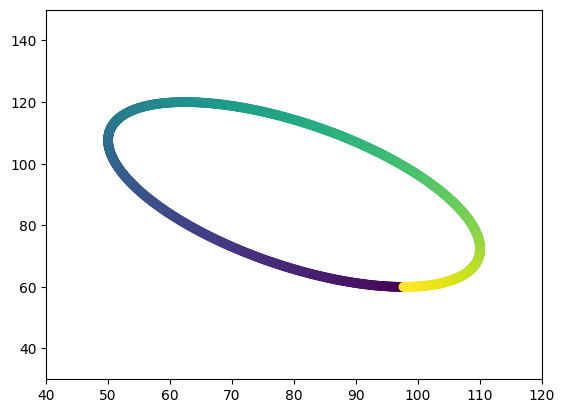

In [52]:
leg_y = 90  # [30, 150]
leg_y_amplitude = 30  # [0, 60]
leg_x = 80  # [40, 140]
leg_x_amplitude = 30  # [0, 50]
ellipse_angle = 0.4  # [0, 1]
pi_cyc = np.linspace(0,2*np.pi,1000)
y_theta = leg_y - leg_y_amplitude * np.cos(pi_cyc)  # Calculate angle from body plane to leg in vertical
y_theta = np.where(y_theta < 40, 40, y_theta)
y_theta = np.where(y_theta > 140, 140, y_theta)
LL_y_angle = y_theta
RL_y_angle = 180 - y_theta  # Invert for right leg
# Calculate angle from body plane to leg in vertical
x_theta = leg_x + leg_x_amplitude * np.sin(pi_cyc + 2 * np.pi * ellipse_angle)

x_theta = np.where(x_theta < 40, 40, x_theta)
x_theta = np.where(x_theta > 120, 120, x_theta)

RL_x_angle = x_theta
LL_x_angle = 180 - RL_x_angle


plt.scatter(x_theta,y_theta, c=np.linspace(0,1,1000), cmap='viridis')
plt.xlim(40,120)
plt.ylim(30,150)
plt.show()

This are the parameters that were chosen for the next tests

leg_x = np.interp(leg_x, [0, 1], [40, 120])
leg_y = np.interp(leg_y, [0, 1], [30, 150])
leg_x_amplitude = np.interp(leg_x_amplitude, [0, 1], [0, 40])
leg_y_amplitude = np.interp(leg_y_amplitude, [0, 1], [0, 60])

Fazit:
I discovered that the weird behaviour I saw was the result of the combination of a diagonal movement and the border boundaries.